##### 這邊是先做pca的但是後面的步驟都不會有變

In [1]:
import os
import cv2
import numpy as np

DATA_DIR = "flowers"
IMG_SIZE = 128


X = []
y = []

label_map = {
    "daisy": 0,
    "dandelion": 1,
    "rose": 2,
    "sunflower": 3,
    "tulip": 4
}
# 這邊是把圖片變成向量 就類似csv
for label_name, label in label_map.items():
    folder = os.path.join(DATA_DIR, label_name)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 這邊可以變成灰階
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # 這邊是用來變成128*128
        X.append(img.flatten())   # 128×128 → 16384
        y.append(label)

# 這邊把它變成numpy
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(4317, 16384) (4317,)


- 我讓他變數保留0.95

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 初始化標準化器
scaler = StandardScaler()

# 2. 先將原始資料 X 轉成標準常態分佈 (mean=0, std=1)
# 這步非常關鍵，能解決之後 statsmodels 的數值爆炸問題
X_scaled = scaler.fit_transform(X)

# 3. 再放入 PCA
pca = PCA(n_components=0.95)  # 保留 95% 的變異量
X_pca = pca.fit_transform(X_scaled)

print("原始資料形狀:", X.shape)
print("標準化並 PCA 後的形狀:", X_pca.shape)

原始資料形狀: (4317, 16384)
標準化並 PCA 後的形狀: (4317, 1155)


- 可以發現它變數變成只剩下1133 從16384 -> 1133

- 一樣拿同一個照片出來看看

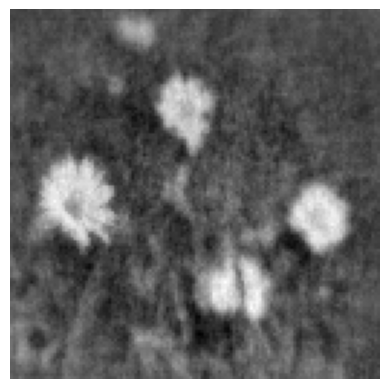

花朵編號： 0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
# 投射回原空間
X_reconstructed = pca.inverse_transform(X_pca)

idx = 100

image = X_reconstructed[idx].reshape(128, 128)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

print("花朵編號：", y[idx])


In [4]:
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Heiti TC'  # 或 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False   # 解決負號顯示成方框



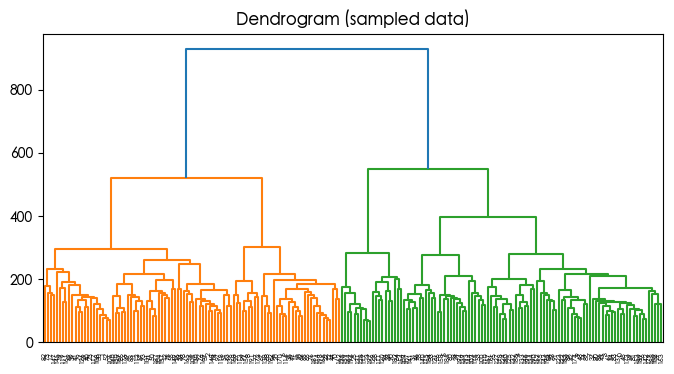

In [5]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

idx = np.random.choice(len(X_pca), size=200, replace=False)

linked_sub = linkage(X_pca[idx], method='ward')

plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=None   # 先畫完整樹
)
plt.title("Dendrogram (sampled data)")
plt.show()


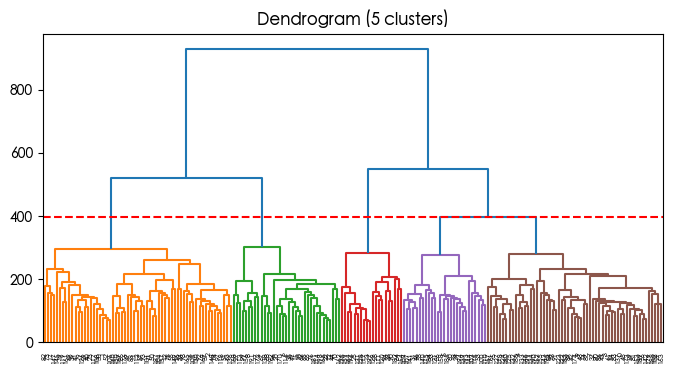

In [6]:
plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=linked_sub[-4, 2]  # 關鍵這一行
)
plt.title("Dendrogram (5 clusters)")
cut_height = linked_sub[-4, 2]
plt.axhline(y=cut_height, color='r', linestyle='--')
plt.show()


In [7]:
from scipy.cluster.hierarchy import linkage

linked = linkage(X_pca, method='ward')
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(linked, t=5, criterion='maxclust')

print(cluster_labels.shape)  # (4317,)
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)



(4317,)
Adjusted Rand Index (ARI): 0.014535561771546763


- 可以發現效果還是很差 但是也不太意外因為還是太難看出差別了

In [8]:
import pandas as pd

ct = pd.crosstab(
    cluster_labels,
    y,
    rownames=["Cluster"],
    colnames=["True Label"]
)

print(ct)


True Label    0    1    2    3    4
Cluster                            
1           212  272  167   42  128
2           123  162  187   59  192
3            69   76   80   99   76
4            30   65   53  142  141
5           330  477  297  391  447


<hr>

- k mean

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=20
)

kmeans_labels = kmeans.fit_predict(X_pca)


In [10]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y, kmeans_labels)
print("KMeans ARI:", ari_kmeans)


KMeans ARI: 0.02240303355847149


In [11]:
import pandas as pd

ct_kmeans = pd.crosstab(
    kmeans_labels,
    y,
    rownames=["KMeans Cluster"],
    colnames=["True Label"]
)

print(ct_kmeans)


True Label        0    1    2    3    4
KMeans Cluster                         
0               176  292  217  283  360
1               182  218  222   58  221
2                71  131  102  206  221
3               126  156  111  143  102
4               209  255  132   43   80


- 這邊也是很差但是也不意外

<hr>

- 不同方式

In [12]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(
    n_clusters=5,
    metric="euclidean",
    random_state=42,
    method="pam"
)

kmedoids_labels = kmedoids.fit_predict(X_pca)


In [13]:
ari_kmedoids = adjusted_rand_score(y, kmedoids_labels)
print("KMedoids ARI:", ari_kmedoids)


KMedoids ARI: 0.017053797645661582


In [14]:
ct_kmedoids = pd.crosstab(
    kmedoids_labels,
    y,
    rownames=["KMedoids Cluster"],
    colnames=["True Label"]
)

print(ct_kmedoids)


True Label          0    1    2    3    4
KMedoids Cluster                         
0                  71  130  116  172  236
1                  85  140  104  183  104
2                 307  376  318  100  321
3                 240  357  209  249  277
4                  61   49   37   29   46


In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=10,        # 這個要調
    min_samples=5  # 常見 5~20
)

db_labels = dbscan.fit_predict(X_pca)


In [16]:
import numpy as np

unique_labels = np.unique(db_labels)
print("Unique cluster labels:", unique_labels)

n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(db_labels == -1)

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)


Unique cluster labels: [-1]
Number of clusters: 0
Number of noise points: 4317


In [17]:
from sklearn.metrics import adjusted_rand_score

ari_dbscan = adjusted_rand_score(y, db_labels)
print("DBSCAN ARI:", ari_dbscan)


DBSCAN ARI: 0.0


- 用lda試試看

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_lda = lda.fit_transform(X_pca, y)

print("LDA 後維度:", X_lda.shape)


LDA 後維度: (4317, 4)


In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 建立 LDA 模型
lda = LinearDiscriminantAnalysis()

lda.fit(X_pca, y)                 
lda_labels = lda.predict(X_pca)   

print(lda_labels.shape)

(4317,)


In [28]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y, lda_labels))


Accuracy: 0.6400277970813064


In [29]:
from sklearn.metrics import adjusted_rand_score
print("ARI:", adjusted_rand_score(y, lda_labels))


ARI: 0.29848168270045894


- 可以發現效果很差，這個原因後面會說

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

lda = LinearDiscriminantAnalysis()
lda.fit(X_pca, y)

eigenvalues = lda.explained_variance_ratio_ / (1 - lda.explained_variance_ratio_)
canonical_r2 = eigenvalues / (1 + eigenvalues)

print("Eigenvalues:", eigenvalues)
print("Canonical R²:", canonical_r2)


Eigenvalues: [0.57167994 0.39963578 0.25637028 0.17188938]
Canonical R²: [0.36373814 0.28552841 0.20405631 0.14667714]


- 這邊是來看看lda四維分別解釋了多少

- 再做做看logistic

In [31]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

logistic.fit(X_pca, y)                 # 訓練
logistic_labels = logistic.predict(X_pca)  # 預測

print(logistic_labels.shape)


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(4317,)


In [32]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y, logistic_labels))


Accuracy: 0.7808663423673847


In [33]:
from sklearn.metrics import adjusted_rand_score
print("ARI:", adjusted_rand_score(y, logistic_labels))


ARI: 0.5236513334673255


- 可以發現這邊準確度還是比沒有做還低

- 因為他變數還是太多了所以我先拿前面50個來看看

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. 修正切分比例：確保 train 是大份的 (test_size=0.2 表示 20% 當測試)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)



# 4. Logistic Regression
# 修正警告：新版 sklearn 建議不需特別指定 multi_class，預設就是 auto/multinomial
logistic = LogisticRegression(
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

logistic.fit(X_train_pca, y_train)
y_pred = logistic.predict(X_test_pca)

# 5. 再次檢查結果
print(f"Train Data Shape: {X_train_pca.shape} (應該要比較大)")
print(f"Test Data Shape: {X_test_pca.shape} (應該要比較小)")
print("-" * 30)
print("New Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Train Data Shape: (3453, 4310) (應該要比較大)
Test Data Shape: (864, 4310) (應該要比較小)
------------------------------
New Accuracy: 0.26157407407407407

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.24      0.22       153
           1       0.25      0.26      0.26       210
           2       0.21      0.23      0.22       157
           3       0.33      0.26      0.29       147
           4       0.33      0.31      0.32       197

    accuracy                           0.26       864
   macro avg       0.27      0.26      0.26       864
weighted avg       0.27      0.26      0.26       864



/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 初始化標準化器
scaler = StandardScaler()

# 2. 先將原始資料 X 轉成標準常態分佈 (mean=0, std=1)
# 這步非常關鍵，能解決之後 statsmodels 的數值爆炸問題
X_scaled = scaler.fit_transform(X)

# 3. 再放入 PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

print("原始資料形狀:", X.shape)
print("標準化並 PCA 後的形狀:", X_pca.shape)

原始資料形狀: (4317, 16384)
標準化並 PCA 後的形狀: (4317, 50)


In [20]:
import statsmodels.api as sm
import pandas as pd

# 1. 重要：Statsmodels 不會像 sklearn 自動加截距項 (Intercept/Bias)
# 必須手動加入常數項，否則模型會強制通過原點
X_pca_const = sm.add_constant(X_pca)

# 2. 建立模型 (MNLogit 對應 sklearn 的 multi_class='multinomial')
# y 是你的目標變數，X_pca_const 是特徵
model = sm.MNLogit(y, X_pca_const)

# 3. 擬合模型
# method='bfgs' 對應 sklearn 的 solver='lbfgs' (或是讓它自動選擇)
result = model.fit(method='bfgs', maxiter=2000)

# 4. 顯示完整的統計報表
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.466772
         Iterations: 102
         Function evaluations: 117
         Gradient evaluations: 117
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 4317
Model:                        MNLogit   Df Residuals:                     4113
Method:                           MLE   Df Model:                          200
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                 0.08238
Time:                        14:43:28   Log-Likelihood:                -6332.1
converged:                       True   LL-Null:                       -6900.5
Covariance Type:            nonrobust   LLR p-value:                8.750e-131
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4065      0.054   

- LLR p-value: 1.845e-129  這邊可以看出來其實還可以
- Df Model: 200  ,  這邊$\beta_i$有200個

- 不能說很好但還是有用

- LLR p-value (8.750e-131)代表還是有用的

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) 加截距項
X_stats = sm.add_constant(X_pca, has_constant="add")
y_stats = y

# 2) 建模與擬合
model = sm.MNLogit(y_stats, X_stats)
result = model.fit(method="bfgs", maxiter=200, disp=False)

# 3) 用機率做預測（MNLogit 的核心）
probs = np.asarray(result.predict(X_stats))  # shape: (n_samples, n_classes)
y_pred = probs.argmax(axis=1)

# 4) 準確率
acc = (y_pred == y_stats).mean()
print("In-sample accuracy:", acc)

# 5) 混淆矩陣（交叉表）
ct = pd.crosstab(y_pred, y_stats, rownames=["Pred"], colnames=["True"])
print(ct)

# 6) 統計上的 fit 指標
print("llf (log-likelihood):", result.llf)
print("llnull (null ll):", result.llnull)
print("McFadden pseudo-R2:", result.prsquared)
print("LR test stat (llr):", result.llr)
print("LR test p-value:", result.llr_pvalue)
print("AIC:", result.aic)
print("BIC:", result.bic)


In-sample accuracy: 0.3687746119990734
True    0    1    2    3    4
Pred                         
0     202  117   71   42   67
1     282  536  249  142  208
2      61   70  106   48   88
3      61  102  108  261  134
4     158  227  250  240  487
llf (log-likelihood): -6332.056421000352
llnull (null ll): -6900.536298532432
McFadden pseudo-R2: 0.08238198495571725
LR test stat (llr): 1136.9597550641593
LR test p-value: 8.750263053919532e-131
AIC: 13072.112842000704
BIC: 14371.657305094022


- llf(log-likelihood): -6332.056421000352  , llnull(null ll): -6900.536298532432
- 這兩個相除會是McFadden pseudo-R2: 0.08238198495571725


- 這邊我讓他保留程度變成0.999999,後面會解釋

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 初始化標準化器
scaler = StandardScaler()

# 2. 先將原始資料 X 轉成標準常態分佈 (mean=0, std=1)
# 這步非常關鍵，能解決之後 statsmodels 的數值爆炸問題
X_scaled = scaler.fit_transform(X)

# 3. 再放入 PCA
pca = PCA(n_components=0.99999999)
X_pca = pca.fit_transform(X_scaled)

print("原始資料形狀:", X.shape)
print("標準化並 PCA 後的形狀:", X_pca.shape)

原始資料形狀: (4317, 16384)
標準化並 PCA 後的形狀: (4317, 4310)


- 這邊做做lda

- 會變成組數-1

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# 1. 初始化標準化器
scaler = StandardScaler()

# 2. 先將原始資料 X 轉成標準常態分佈 (mean=0, std=1)
# 這步非常關鍵，能解決之後 statsmodels 的數值爆炸問題
X_scaled = scaler.fit_transform(X)

# 3. 再放入 PCA
pca = PCA(n_components=0.99999)
X_pca = pca.fit_transform(X_scaled)

lda = LinearDiscriminantAnalysis()

X_lda = lda.fit_transform(X_pca, y)

print("LDA 後維度:", X_lda.shape)


LDA 後維度: (4317, 4)


In [28]:
import numpy as np

# 1. 檢查 y 的類別數量
print("y 的獨立類別數量:", len(np.unique(y)))
print("y 的類別內容:", np.unique(y))

# 2. 或者直接查看訓練好的 LDA 模型屬性
print("LDA 模型識別出的類別:", lda.classes_)

y 的獨立類別數量: 5
y 的類別內容: [0 1 2 3 4]
LDA 模型識別出的類別: [0 1 2 3 4]


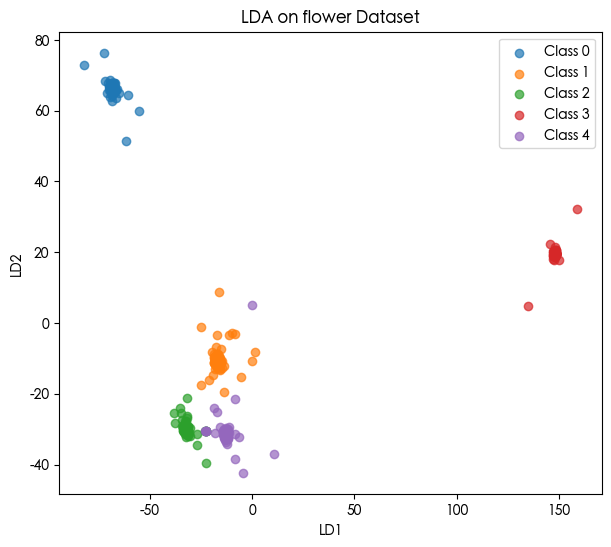

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

for label in [0, 1, 2 , 3 , 4]:
    plt.scatter(
        X_lda[y == label, 0],
        X_lda[y == label, 1],
        label=f"Class {label}",
        alpha=0.7
    )

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA on flower Dataset")
plt.legend()
plt.show()


設定: 20 | PCA後維度: 20 | 解釋變異量總和: 0.6369
設定: 100 | PCA後維度: 100 | 解釋變異量總和: 0.7759
設定: 0.95 | PCA後維度: 1133 | 解釋變異量總和: 0.9500
設定: 0.999 | PCA後維度: 3806 | 解釋變異量總和: 0.9990
設定: 0.99999 | PCA後維度: 4286 | 解釋變異量總和: 1.0000
設定: 0.9999999999 | PCA後維度: 4310 | 解釋變異量總和: 1.0000


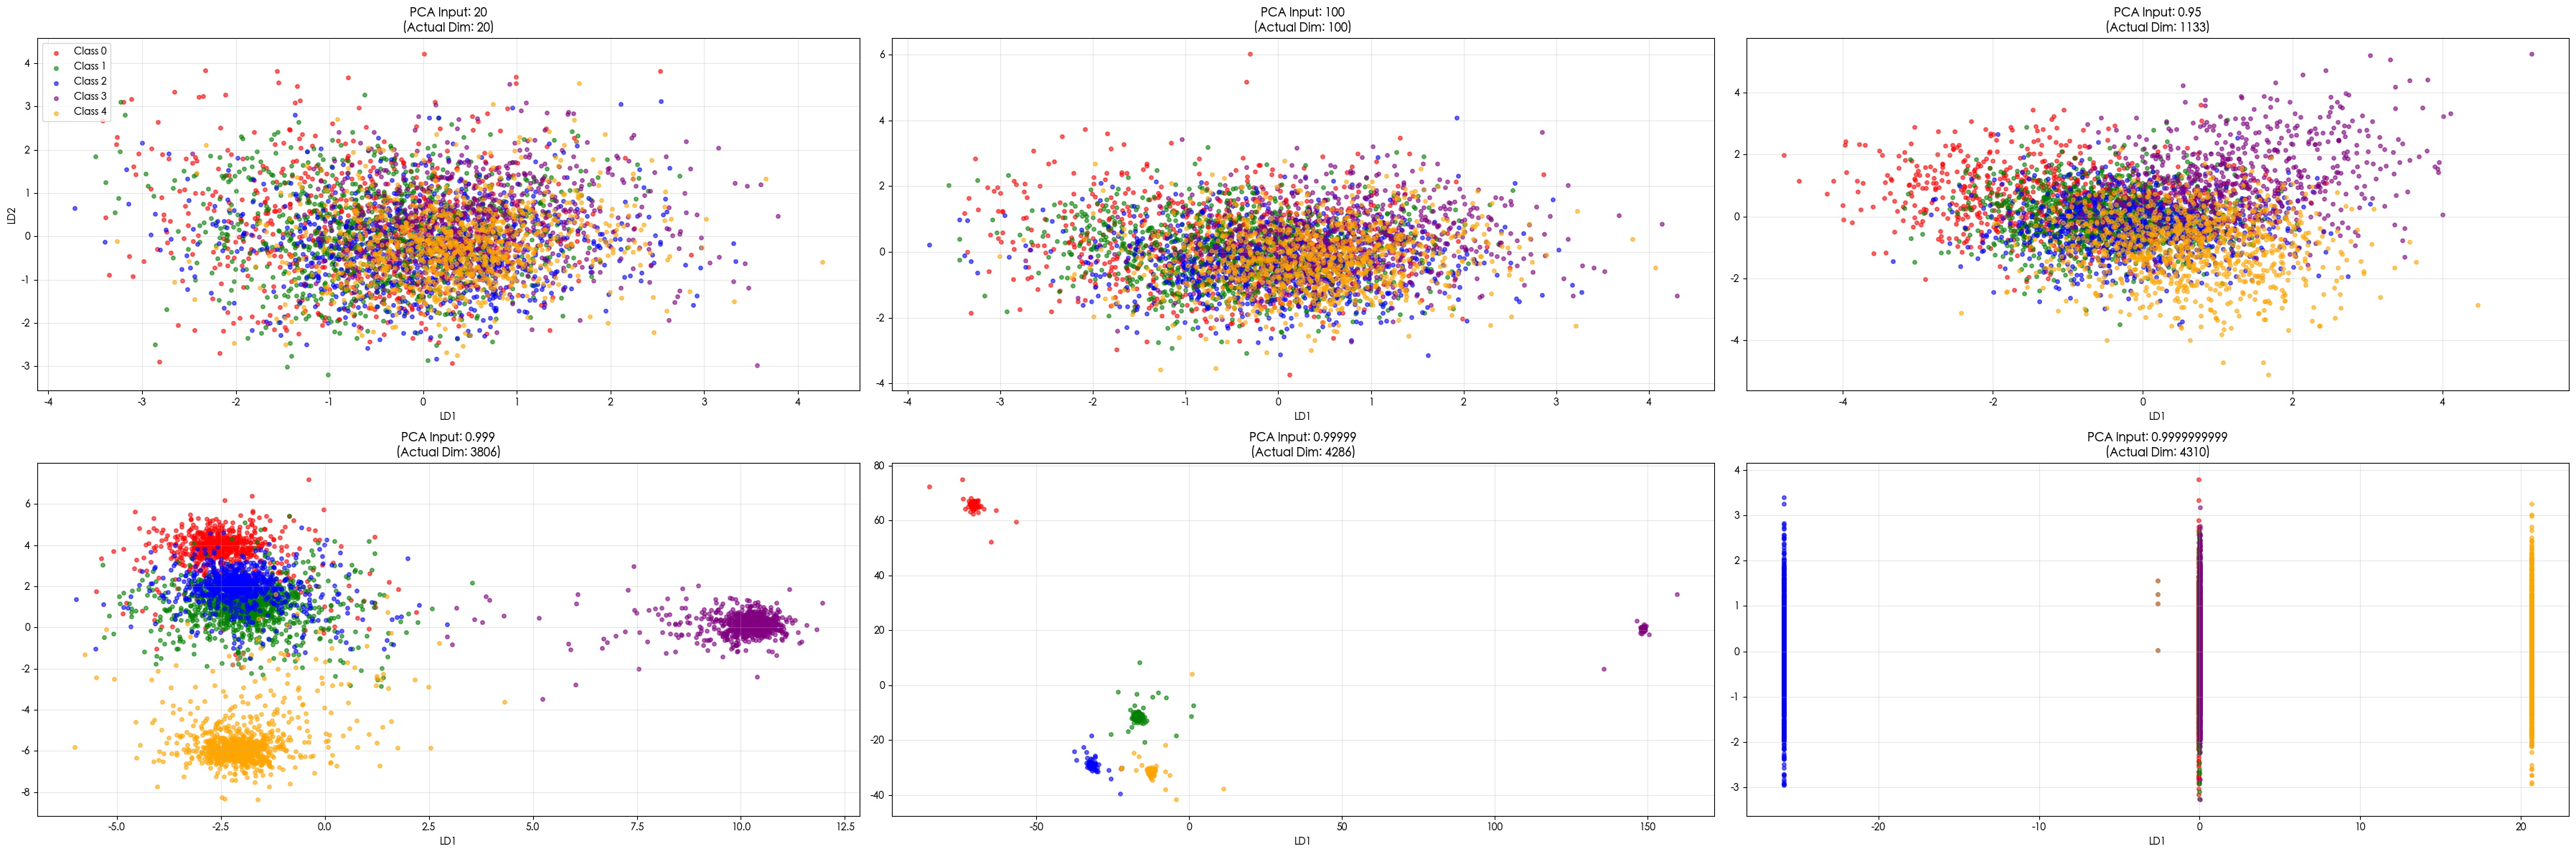

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca_configs = [20, 100, 0.95, 0.999, 0.99999, 0.9999999999]

fig, axes = plt.subplots(2, 3, figsize=(36, 12))
axes = axes.flatten()  

colors = ['red', 'green', 'blue', 'purple', 'orange']

for i, n_comp in enumerate(pca_configs):
    ax = axes[i]

    # 1. PCA
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X)

    # 2. LDA
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_lda = lda.fit_transform(X_pca, y)

    current_dim = X_pca.shape[1]
    print(
        f"設定: {n_comp} | PCA後維度: {current_dim} | "
        f"解釋變異量總和: {pca.explained_variance_ratio_.sum():.4f}"
    )

    # 3. 繪圖
    for label in [0, 1, 2, 3, 4]:
        ax.scatter(
            X_lda[y == label, 0],
            X_lda[y == label, 1],
            alpha=0.6,
            s=15,
            color=colors[label],
            label=f"Class {label}"
        )

    ax.set_title(f"PCA Input: {n_comp}\n(Actual Dim: {current_dim})")
    ax.set_xlabel("LD1")
    if i == 0:
        ax.set_ylabel("LD2")
    ax.grid(True, alpha=0.3)

# 只在第一張圖顯示 legend
axes[0].legend(loc="upper left")

plt.tight_layout()
plt.show()


- 因為我們拿花本體的樣子出來看他在前面的pca參數中其實都長得差不多，能判斷出差別的都集中在剩下的
- 這也是為什麼效果不好的主要原因

- 可以看一下這邊的結果接下來我會把這邊的結果用在lda中